# FISH decoding

Aim:  
Identify RNA species from spots coordinates `[round, z, y, x]` and a codebook `{roud | barcode: species}` for non barcoded and barcoded FSIH experiments.

In [1]:
import numpy as np
import pandas as pd
from localize_psf import fish
from localize_psf import decode
from importlib import reload

In [3]:
reload(decode)

<module 'localize_psf.decode' from '/home/alexis/Documents/Pro/Postdoc_ASU/from_lab/Projects/localize-psf/localize_psf/decode.py'>

In [4]:
species = ['a', 'b', 'c']
n_spots = 3
tile_shape = [25, 250, 500]
codebook = {'a': '01', 'b': '10', 'c': '11'}
coords = decode.generate_barcoded_spots(species, n_spots, tile_shape, codebook)

In [5]:
coords

,z,y,x,rounds,species
0,20.904648,21.117879,30.041773,1,a
1,15.581646,111.508819,496.129627,1,a
2,4.695601,38.349943,84.725115,1,a
3,21.128554,93.936517,430.722955,0,b
4,9.281738,25.198916,172.996232,0,b
5,23.422782,218.378095,484.580046,0,b
6,17.056078,11.713500,80.650767,0,c
7,18.008513,128.665228,450.680225,0,c
8,4.959338,220.610608,238.513446,0,c
9,17.056078,11.713500,80.650767,1,c


In [7]:
def identify_barcoded_spots(coords, codebook, distances):
    """
    Parameters
    ----------
    coords : DataFrame
        Coordinates of all spots.
    codebook : dict
        Association from species to rounds.
    
    Returns
    -------
    species : DataFrame
        Decoded FISH spots identities with their coordinates.

    Example
    -------
    >>> species_labels = ['a', 'b', 'c']
    >>> n_spots = 10
    >>> tile_shape = [50, 250, 500]
    >>> coords, codebook = generate_nonbarcoded_spots(species_labels, n_spots, tile_shape)
    >>> measured_coords = coords.drop(columns=['species'])
    >>> identify_nonbarcoded_spots(measured_coords, codebook)
    """

    nb_rounds = len(next(iter(codebook.values())))
    # make dictionnary barcode --> species from dictionnary species --> barcode
    inv_codebook = {val: key for key, val in codebook.items()}
    max_z = distances[0]
    max_xy = distances[1]
    
    # max projection of coordinates over rounds:
    # ignore the round information and fuse neighbooring spots
    proj_coords = coords.iloc[:, 0:3]
    # proj_coords = fish.merge_peaks(proj_coords, max_z=distances[0], max_xy=distances[1], weights=None, method='network', verbose=True)
    nb_nodes = len(proj_coords)
    for node_id in range(nb_nodes):
        for round_id in range(nb_rounds):
            # build the radial distance network using the bigest radius: max distance along z axis
            pairs = ty.build_rdn(coords=proj_coords, r=max_z)
            if len(pairs) == 0:
                # all nodes are well separated from each other, do nothing
                merged_coords = proj_coords
            else:
                # fuse nodes that have too close neighbors
                source = proj_coords[pairs[:, 0]]
                target = proj_coords[pairs[:, 1]]
                # compute the 2 distances arrays
                dist_z, dist_xy = fish.compute_distances(source, target)
                # perform grph cut from the 2 distance thresholds
                _, pairs = fish.cut_graph_bidistance(dist_z, dist_xy, max_z, max_xy, pairs=pairs)




Barcode reconstruction algorithm:
  - for each spot in each round, we reconstruct all potential barcodes:
    - we look for its neighbors in a given radius across rounds, there can be multiple ones per round
    - if there is at least 1 neighbors in a round, the corresponding barcode bit is 1, else 0
  - clean redundant barcodes related to same locations:
    - merge identical barcodes within the same area
    - keep differing barcodes within the same area

If barcode reconstruction per round is a single function, it's easy to parallelize per round. If we have many more cores, we can split spots coordinates per round across several cores.

In [8]:
a = np.arange(20) 
# for i in np.nditer(a, op_flags=['readwrite']):
#     print(i)
#     print(a)
#     a = np.delete(a, i+1)
#     print(a)

# i = 0
# while i < len(a):
#     print(i, a[i])
#     print(a)
#     a = np.delete(a, i+1)
#     print(a)
#     i += 1

a = np.array([[1, 1], [0, 1], [2, 3], [3, 1], [4, 4], [5, 4]])



k = 0
while k < len(a):
    i, j = a[k]
    print(k, a[k])
    print(a)
    if i == j:
        a = a[a[:, 1] != j, :]
    else:
        k += 1
    print(a)
    


0 [1 1]
[[1 1]
 [0 1]
 [2 3]
 [3 1]
 [4 4]
 [5 4]]
[[2 3]
 [4 4]
 [5 4]]
0 [2 3]
[[2 3]
 [4 4]
 [5 4]]
[[2 3]
 [4 4]
 [5 4]]
1 [4 4]
[[2 3]
 [4 4]
 [5 4]]
[[2 3]]


In [63]:
species = ['a', 'b', 'c']
n_spots = 3
tile_shape = [25, 250, 500]
codebook = {'a': '01', 'b': '10', 'c': '11'}
coords_df = decode.generate_barcoded_spots(species, n_spots, tile_shape, codebook)
# round coordinates for readability
coords_df.iloc[:, :3] = np.round(coords_df.iloc[:, :3], 2)

In [64]:
coords_df

,z,y,x,rounds,species
0,10.87,116.39,181.66,1,a
1,12.59,223.82,267.36,1,a
2,4.59,206.72,2.06,1,a
3,2.78,3.64,434.57,0,b
4,14.23,60.10,498.79,0,b
5,8.04,245.03,257.65,0,b
6,14.64,214.89,71.46,0,c
7,0.03,184.91,15.89,0,c
8,13.84,138.63,30.03,0,c
9,14.64,214.89,71.46,1,c


In [65]:
coords = decode.df_to_listarray(coords_df, 'rounds', ['z', 'y', 'x'])
coords

[array([[1.0870e+01, 1.1639e+02, 1.8166e+02],
        [1.2590e+01, 2.2382e+02, 2.6736e+02],
        [4.5900e+00, 2.0672e+02, 2.0600e+00],
        [1.4640e+01, 2.1489e+02, 7.1460e+01],
        [3.0000e-02, 1.8491e+02, 1.5890e+01],
        [1.3840e+01, 1.3863e+02, 3.0030e+01]]),
 array([[2.7800e+00, 3.6400e+00, 4.3457e+02],
        [1.4230e+01, 6.0100e+01, 4.9879e+02],
        [8.0400e+00, 2.4503e+02, 2.5765e+02],
        [1.4640e+01, 2.1489e+02, 7.1460e+01],
        [3.0000e-02, 1.8491e+02, 1.5890e+01],
        [1.3840e+01, 1.3863e+02, 3.0030e+01]])]

In [72]:
reload(decode)
coords = decode.df_to_listarray(coords_df, 'rounds', ['z', 'y', 'x'])
species, coords, barcodes = decode.decode_spots(
    coords=coords,
    codebook=codebook,
    dist_params=(0.1, 0.1), 
    clean_min=1, 
    clean_max=3,
    )


In [73]:
species

['b', 'b', 'b', 'c', 'c', 'c', 'a', 'a', 'a']

In [74]:
barcodes

['10', '10', '10', '11', '11', '11', '01', '01', '01']

In [75]:
coords

array([[1.0870e+01, 1.1639e+02, 1.8166e+02],
       [1.2590e+01, 2.2382e+02, 2.6736e+02],
       [4.5900e+00, 2.0672e+02, 2.0600e+00],
       [1.4640e+01, 2.1489e+02, 7.1460e+01],
       [3.0000e-02, 1.8491e+02, 1.5890e+01],
       [1.3840e+01, 1.3863e+02, 3.0030e+01],
       [2.7800e+00, 3.6400e+00, 4.3457e+02],
       [1.4230e+01, 6.0100e+01, 4.9879e+02],
       [8.0400e+00, 2.4503e+02, 2.5765e+02]])

In [216]:
reload(decode)

<module 'localize_psf.decode' from '/home/alexis/Documents/Pro/Postdoc_ASU/from_lab/Projects/localize-psf/localize_psf/decode.py'>

In [226]:
species = ['a', 'b', 'c']
n_spots = 3
tile_shape = [25, 250, 250]
codebook = {'a': '01', 'b': '10', 'c': '11'}
noise = 1.0
coords_df, true_coords = decode.generate_barcoded_spots(species, n_spots, tile_shape, codebook, noise=noise)

In [227]:
coords_df

,z,y,x,rounds,species
0,21.043297,113.474992,141.630903,1,a
1,21.354492,192.717120,38.977982,1,a
2,3.776233,16.151990,82.618791,1,a
3,18.471788,3.614171,238.581713,0,b
4,19.348922,229.572685,218.662635,0,b
5,1.889816,89.103530,207.413790,0,b
6,2.718013,82.269012,61.836827,0,c
7,4.355218,196.325989,100.673822,0,c
8,4.856124,160.343859,181.708358,0,c
9,2.552005,81.548435,61.776103,1,c


In [228]:
reload(decode)
if noise is None:
    dist_params = (0.00001, 0.00001)
else:
    dist_params = (2*noise, 2*noise)
coords = decode.df_to_listarray(coords_df, 'rounds', ['z', 'y', 'x'])
species, coords, barcodes = decode.decode_spots(
    coords=coords,
    codebook=codebook,
    dist_params=dist_params, 
    clean_min=1, 
    clean_max=3,
    )

In [229]:
species

['b', 'b', 'b', 'c', 'c', 'c', 'a', 'a', 'a']

In [230]:
coords

array([[ 18.47178802,   3.61417098, 238.58171283],
       [ 19.34892169, 229.57268516, 218.66263461],
       [  1.88981593,  89.10352991, 207.41379025],
       [  2.71801314,  82.26901222,  61.83682703],
       [  4.35521767, 196.32598904, 100.67382157],
       [  4.85612401, 160.34385853, 181.70835771],
       [ 21.04329702, 113.47499213, 141.63090265],
       [ 21.35449165, 192.71712034,  38.97798212],
       [  3.77623263,  16.15198976,  82.6187909 ]])

In [231]:
true_coords

,z,y,x,species
0,20.860476,112.935607,142.151447,a
1,20.379955,192.385847,38.688579,a
2,3.234660,17.108654,81.791249,a
3,18.329165,3.311081,239.011274,b
4,18.882093,229.999421,218.403805,b
5,2.088186,89.110141,207.683008,b
6,3.499061,81.769390,61.403382,c
7,3.390457,195.342278,101.630623,c
8,4.295044,160.060460,180.892379,c


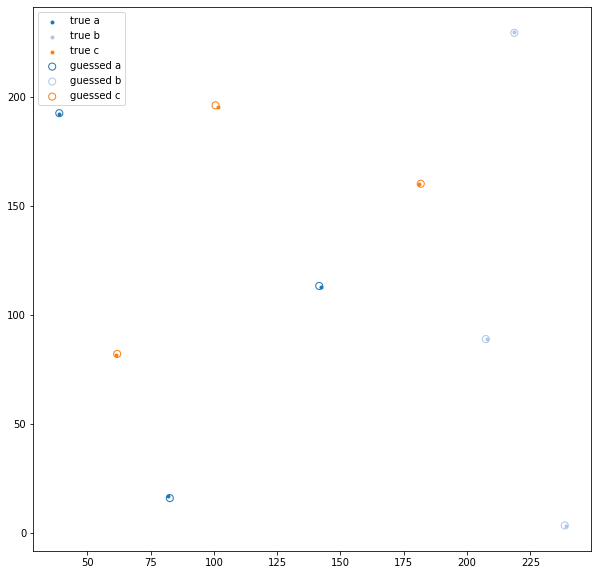

In [232]:
reload(decode)
decode.plot_compare_decoded_spots(
    true_coords.loc[:, ['y', 'x']], 
    true_species=true_coords['species'], 
    guessed_coords=coords, 
    guessed_species=species, 
    figsize=(10, 10))